In [91]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [92]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils
from stompy.grid import unstructured_grid
from matplotlib import colors
import os
import numpy as np
import xarray as xr
import subprocess
from IPython.display import Video
import time
import six
import datetime
import glob
from stompy.plot import nbviz

In [85]:
# run_wy2022_bloom_common_20220810:
#   dye1, oakland release, non-temp hydro
# run_wy2022_bloom_common_20220810-v001
#   oakland, eastshore releases. temp hydro.
# run_wy2022_bloom_common_20220810-v002
#   oakland release, temp hydro, 16.62 integration
# run_wy2022_bloom_common_20220810-v003"
#   oakland release in top 2m of water column
# run_wy2022_bloom_common_20220515-v002
#   testing custom tracer
# run_wy2022_bloom_common_20220810-v007
#   age and depth tracers
# run_wy2022_bloom_common_20220810-v007
#   age and depth tracers for continuous release.
# run_wy2022_bloom_common_20220705
#   age and depth tracers for continuous release, longer period w/ EBDA
#   EBDA exposure misconfigured
# run_wy2022_bloom_common_20220705-v001
#   fix EBDA exposure
# run_wy2022_bloom_common_20220705-v003
#   LSB exposure, age variance, 0.1/day decay of EBDA and LSB
#   has variance, but it's broken.
# run_wy2022_bloom_common_20220705-v004
#   Should have variance fixed now
# run_wy2022_bloom_common_20220705-v005
#   Conservative/decaying tracers for EBDA and LSB 
# run_wy2022_bloom_common_20220802
#   Start at the time of release, and drop the extra POTW tracers
# run_wy2022_bloom_common_20220805-v007
#   Add light exposure, short run for testing. 
# run_wy2022_bloom_common_20220802-v001
#   With light exposure, longer run. But light exposure seems to be broken.
# run_wy2022_bloom_common_20220802-v001
#   Use RadBot instead of Rad
run_dir="run_wy2022_bloom_common_20220802-v002"


In [149]:
ds=xr.open_dataset(os.path.join(run_dir,"dwaq_map.nc"))

In [87]:
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ds)

In [88]:
def ratio(a,b,b_min=1e-8):
    return a/b.clip(b_min) * np.where(b<b_min,np.nan, 1.0)

<IPython.core.display.Javascript object>


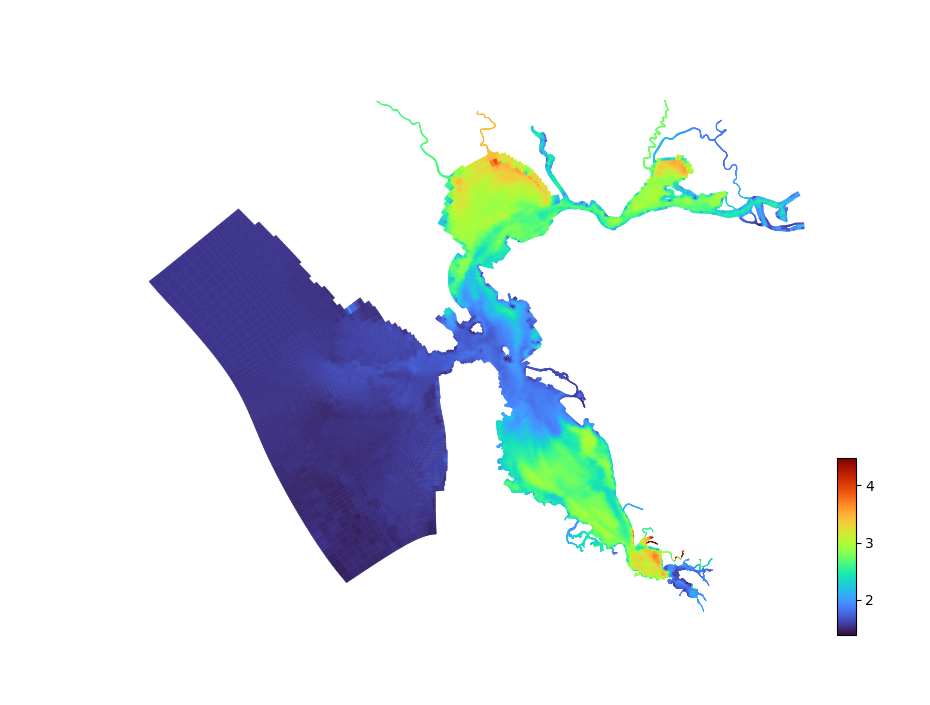

NBViz(children=(VBox(children=(Label(value='Coordinates'),), layout=Layout(grid_area='header')), Select(descri…

Will update/create coordinate pane
Set variable and requested Fig.redraw()
Set variable and requested Fig.redraw()
Set variable and requested Fig.redraw()
Set variable and requested Fig.redraw()


In [93]:
six.moves.reload_module(nbviz)
# dev: eventually automate more of this.
def safe_ratio(numer,denom,thresh=1e-5):
    def func(src,dims):
        thresh=1e-5
        v_numer=src(numer,dims)
        v_denom=src(denom,dims)
        return v_numer / v_denom.clip(thresh)
    return func

def radio_age(cons,decay,rate=0.10):
    fratio=safe_ratio(decay,cons)
    def func(src,dims):
        rat = fratio(src,dims)
        return np.log(rat)/np.log(1-rate)
    return func

def stddev(conc,age_conc,var_conc):
    f_age=safe_ratio(age_conc,conc)
    f_mom2=safe_ratio(var_conc,conc)
    
    def func(src,dims,f_age=f_age,f_mom2=f_mom2):
        age=f_age(src,dims)
        mom2=f_mom2(src,dims)
        # mostly sure of the factor of 2 here.
        return np.sqrt( mom2-age*age/2 )
    return func

viz=nbviz.NBViz(
    [ds],
    expressions=[
      nbviz.BoundExpression(name='age',dims=['time','layer','face'],func=safe_ratio('Age1AConc','Age1Conc')),
      nbviz.BoundExpression(name='avg_depth',dims=['time','layer','face'],func=safe_ratio('Age1DAConc','Age1AConc')),
      nbviz.BoundExpression(name='avg_rad',dims=['time','layer','face'],func=safe_ratio('Age1RadAge','Age1AConc')),
      #nbviz.BoundExpression(name='avg_ebda',dims=['time','layer','face'],func=safe_ratio('Age1NAConc','Age1AConc')),
      #nbviz.BoundExpression(name='expo_ebda',dims=['time','layer','face'],func=safe_ratio('Age1NAConc','Age1Conc')),
      #nbviz.BoundExpression(name='avg_lsb',dims=['time','layer','face'],func=safe_ratio('Age1LAConc','Age1AConc')),
      #nbviz.BoundExpression(name='expo_lsb',dims=['time','layer','face'],func=safe_ratio('Age1LAConc','Age1Conc')),
      #nbviz.BoundExpression(name="age_lsb",dims=['time','layer','face'],func=radio_age('LSBcon','LSB')),
      #nbviz.BoundExpression(name="age_ebda",dims=['time','layer','face'],func=radio_age('EBDAcon','EBDA')),
        
      nbviz.BoundExpression(name='age_stddev',dims=['time','layer','face'],
                            func=stddev('Age1Conc','Age1AConc','Age1VConc')),
    ])
                

viz 

In [157]:
# # Diagnosing rad tracer
# pnts= [[552100,4.1881e6], # CB
#        [560200,4.1739e6], # Hunters point
#        [564500,4.133e6], # SFO
# ]
# pnt_labels=['CB','Hunter','SFO']


# fig,(ax,ax_d,ax2)=plt.subplots(3,1,sharex=True,figsize=[8.5,7])

# #ax_d = ax.twinx()

# for pnt,pnt_label in zip(pnts,pnt_labels):
#     c=grid.select_cells_nearest(pnt)

#     for k in [1]:
#         #tag=f'(k={k},x={pnt_label})'
#         tag=f'(x={pnt_label})'
        
#         age_conc=ds['Age1AConc'].isel(layer=k,face=c)

#         #ax.plot(ds.time, ds.Rad.isel(layer=k,face=c),label=f'Rad(k={k})')
#         rad_age=ds['Age1RadAge'].isel(layer=k,face=c)
#         #ax.plot(ds.time, rad_age,label=f'RadAge(k={k})')
#         ax.plot(ds.time, rad_age/age_conc,label=f'avg_rad{tag}')
#         #ax.plot(ds.time, rad_age/age_conc.clip(1e-5),label='avg_rad safe')

#         depth_age=ds['Age1DAConc'].isel(layer=k,face=c)
#         #ax_d.plot(ds.time, ds.LocalDepth.isel(layer=k,face=c),label=f'LocDepth(k={k})')
#         #ax.plot(ds.time, depth_age,label=f'DepthAge(k={k})')
#         d_avg= depth_age / age_conc
#         ax_d.plot(ds.time, d_avg,label=f'avg_depth{tag}')

#         # highly inaccurate, but maybe shows relationship:
#         # average of an exponential isn't the same as exponential of the average,
#         # but throw in a fudge factor and it's close.
#         #I0=500
#         #Kd=2.0
#         #ax.plot( ds.time, I0*np.exp(-0.33*Kd*d_avg), label='$\sim I_0 e^{-Kd \overline{h}}$',color='r' )

#         #ax2.plot(ds.time, age_conc,label=f'AgeConc{tag}')
#         #conc=ds['Age1Conc'].isel(layer=k,face=c)
#         #ax2.plot(ds.time, conc,label='conc')
#         #ax2.plot(ds.time, age_conc/conc,label='age')
#         #ax2.plot(ds.time, (ds.time-ds.time.values[0])/np.timedelta64(1,'D'),label='max age')
    
#         kd=ds['ExtVl'].isel(layer=k,face=c)
#         ax2.plot(ds.time, kd,label=f'ExtVl{tag}')
        
# fig.subplots_adjust(right=0.76,left=0.05,top=0.99,bottom=0.08,hspace=0.06)    

# ax.legend(loc='upper left',bbox_to_anchor=[1.01,1])
# ax2.legend(loc='upper left', bbox_to_anchor=[1.01,1])
# ax_d.legend(loc='upper left', bbox_to_anchor=[1.01,1])

# ax_d.axis(ymin=0,ymax=12)
# ax.axis(ymin=0,ymax=60)

In [158]:
frac=0.1
M=grid.smooth_matrix()

INFO:utils:84682/86633


In [159]:
def fill(values,iterations=50):
    valid=np.isfinite(values)
    data=np.where(valid,values,0.0)
    weight=np.where(valid,1,0.0)
    for _ in range(iterations):
        data=M.dot(data)
        weight=M.dot(weight)
        data[valid]=values[valid]
        weight[valid]=1.0
    result=np.full(len(values),np.nan)
    valid=weight>1e-4
    result[valid]=data[valid]/weight[valid]
    return result

In [945]:
# Is it not taking off b/c...
#   c0 too low relative max productivity?
#   light limitation too strong? I think this is it. Dropping Kd to 0.5 gets
#   bloom front, though
#   it's not nutrient limitation. It's not N0

/home/rusty/.conda/envs/general_rh/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


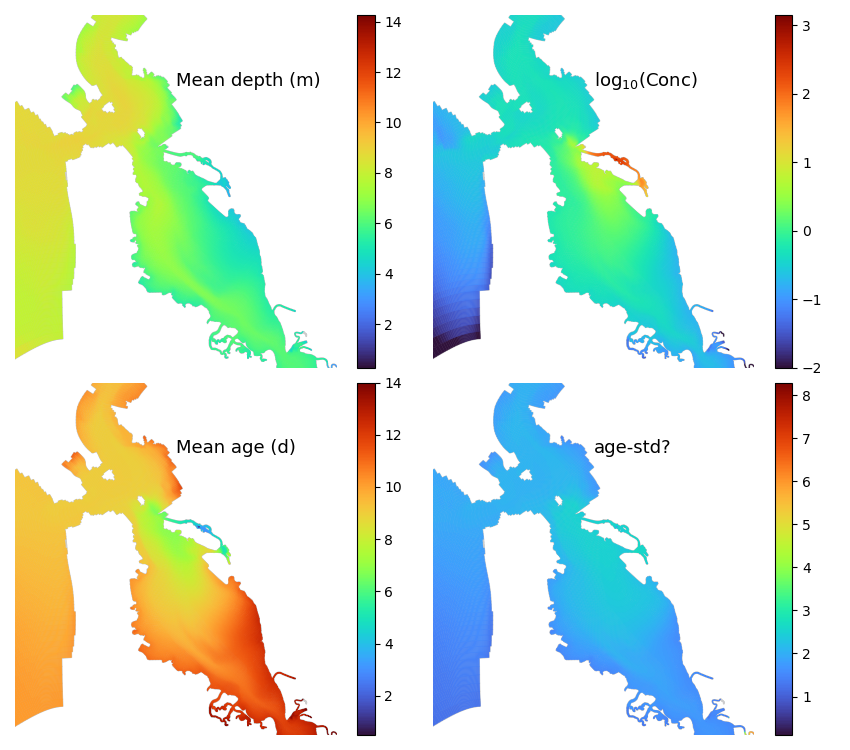

In [160]:
# Choose a time and show the tracer outputs
t=np.datetime64("2022-08-16")
layer=0

zoom=(534866.147091273, 587089.832126076, 4151509.9875591, 4202696.11593758)

age_conc=ds['Age1AConc'].sel(time=t,method='nearest').isel(layer=0)
conc    =ds['Age1Conc'].sel(time=t,method='nearest').isel(layer=0)
age_depth_conc=ds['Age1DAConc'].sel(time=t,method='nearest').isel(layer=0)

max_age=(t-ds.time.values[0])/np.timedelta64(1,'D')
mean_age=ratio(age_conc,conc).clip(0,max_age)

mean_depth=ratio(age_depth_conc, age_conc)
valid=conc.values>=0.008 # covers to just N of DMB, and into Central Bay
H=mean_depth.values

var_conc=ds['Age1VConc'].sel(time=t,method='nearest').isel(layer=0)

scals=[mean_depth,np.log10(conc.clip(1e-2)),
       mean_age,
       #(mean_age**2/2).clip(0,500)
      ]
labels=['Mean depth (m)','log$_{10}$(Conc)','Mean age (d)']

#scals.append(var_conc)
#labels.append('Var.-conc')

#scals.append(ratio(var_conc,conc).clip(0,500))
#labels.append('2nd mom')

scals.append( np.sqrt( (ratio(var_conc,conc) - mean_age**2/2)).clip(0,10))
labels.append('age-std?')


fig,axs=plt.subplots(2,2,figsize=(8.5,7.5))

plt.setp(axs, adjustable='datalim')
for ax in axs.ravel():
    ax.axis('off')
fig.tight_layout()
for i,(ax,scal,label) in enumerate(zip(axs.ravel(),scals,labels)):
    grid.plot_cells(color='0.8',zorder=0,ax=ax)
    ccoll=grid.plot_cells(values=scal,mask=np.isfinite(scal),ax=ax,cmap='turbo',zorder=1,
                          edgecolor='face',lw=0.3)
    ax.axis(zoom)
    plt.colorbar(ccoll,ax=ax)

    ax.text(0.5,0.8,label,transform=ax.transAxes,fontsize=13)


In [161]:
from scipy.integrate import odeint
from numba import njit

class Petri:
    # Original toy parameters
    #I0=100. # insolation
    #Isat=10.
    #N0=35 # initial DIN
    #Nsat=0.5
    #Kd=1.0 # light extinction
    #kmort=0.15 # per day
    #kprod=1.2 # per day, max
    #alpha=0.15 # stoichiometry, uM DIN per ug/l chl production.
    
    # From Pradeep:
    kprod=1.6 # value for Greens
    kmort=0.15 # BGC uses 0.07 for Greens, but doesn't include grazing.
    #    mgN/l:mgC/l    μM N : mgN/l   mgC/l : μg/l Chl (lit. value)
    alpha=0.16         * 71.1        * 30/1000. # ~ 0.34
    Nsat=1.0 # in the middle of Pradeep's 0.7 -- 2 range of lit. values
    Isat=17 # Greens. [W/m2]
    I0=175 # PM: 700-800 peak at Union City. 350-400 daily mean. 175-200 PAR
    Kd=1.0

    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        
    def diff(state,t,Hmean):
        P,N=state
        N=N.clip(0) # no evidence this is really necessary
        P=P.clip(0) # likewise.
        Imean=self.I0*np.exp(-self.Kd*Hmean)
        kLight=Imean/(Imean+self.Isat)
        # duplicate while testing.
        kDIN=N/(N+self.Nsat)
        dgrossP = self.kprod*kLight*kDIN*P
        dnetP = -self.kmort*P + dgrossP
        dN = -self.alpha*dgrossP
        return np.r_[dnetP,dN]

    # t: days
    # c0: phytoplankton as chl ug/l
    # Hmean: meters
    def predict(self, c0, age, Hmean,N0=None, Imean=None):
        if N0 is None:
            N0=self.N0

        if Imean is None:
            Imean=self.I0*np.exp(-self.Kd*Hmean)
            
        kLight=Imean/(Imean+self.Isat)

        age=np.atleast_1d(age)
        if len(age)==1:
            t_vals=np.r_[0,age[0]] # linspace(0,15,200)
        else:
            t_vals=age
            
        params=np.array([self.Nsat,self.kprod*kLight,self.kmort,self.alpha])
        result=odeint(self.nb_diff,[c0,N0],t_vals,tfirst=True,
                      args=(params,))
        
        if len(age)==1:
            return result[-1,:]
        else:
            return result

    @staticmethod
    @njit
    def nb_diff(t,state,params):
        P=max(0,state[0]) # .clip(0)
        N=max(0,state[1]) # .clip(0)
        Nsat=params[0]
        k_prod_light=params[1]
        k_mort=params[2]
        alpha=params[3]
        
        kDIN=N/(N+params[0])
        dgrossP = k_prod_light*kDIN*P
        dnetP = -k_mort*P + dgrossP
        dN = -alpha*dgrossP
        return np.array([dnetP,dN])
        
    def predict_many(self,c0,age,Hmean,N0=None,Imean=None):
        if N0 is None:
            N0=self.N0
        N0=np.atleast_1d(N0)
        
        if Imean is None:
            Imean=self.I0*np.exp(-self.Kd*Hmean)
                    
        t_start=time.time()
        B=np.broadcast(c0,age,Hmean,N0,Imean)
        result=np.zeros(B.shape+(2,),np.float64)
        resultR=result.reshape([-1,2])
        for c0,age,Hmean,N0,I in B:
            resultR[B.index-1,:]=self.predict(c0,age,Hmean,N0,I)
        elapsed=time.time()-t_start
        print(f"Elapsed time for {B.size} samples: {elapsed:.3f}s")
        return result

In [162]:
zoom=(534866.147091273, 587089.832126076, 4151509.9875591, 4202696.11593758)

In [163]:
from stompy.plot import plot_wkb

grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249210, 15 potential interiors


In [165]:
# interesting region for the polygon release:
# source_strength=100 # tracer release is unit concentration. scale up to get source ug/l
# petri_args=dict(Kd=0.4)
from stompy import utils
from scipy import stats # norm

class LiveBloom:
    # dynamic inputs
    source_strength=0.1 # tracer release is unit concentration. scale up to get source ug/l

    c_thresh=0.000
    t=np.datetime64("2022-08-16")
    layer=0
    # post-hoc timing of release
    release_start=np.datetime64("2022-08-02")
    release_sigma_days='auto' # 3
    frac=0.05
    
    # ebda, lsb discharges go into DWAQ at 10000 [g/s]
    # ebda, 2013 average load was 7870 kg/d
    ebda_load=7870 # kg/d, just EBDA.
    lsb_load=2350 + 890 + 4800 # Palo Alto, Sunnyvale, San Jose
    ebda_factor=0.0
    lsb_factor=0.0
    N0=35
    
    # plotting controls
    figsize=(9,7)
    panels=[['Chl-a','DIN','log10(C0)'],
           ['effective_age','mean_depth','mean_rad]]
    
    # constant-ish
    zoom=(534866.147091273, 587089.832126076, 4151509.9875591, 4202696.11593758)
    background=False

    clims={'Chl-a':[0,120],
           'DIN':[0,35],
           'log10(C0)':[-3,2],
           'effective_age':[0,20],
           'mean_depth':[0,10],
           'stddev_age':[0,10],
           'mean_rad':[0,100],
          }
           
    def __init__(self,ds,**kw):
        utils.set_keywords(self,kw)
        self.petri=Petri()
        self.ds=ds
        self.grid=unstructured_grid.UnstructuredGrid.read_ugrid(ds)
        
        # the cell fields to be plotted
        self.conc=np.zeros(self.grid.Ncells())
        self.mean_age=np.zeros(self.grid.Ncells())
        self.mean_depth=np.zeros(self.grid.Ncells())
        self.mean_rad=np.zeros(self.grid.Ncells())
        
        self.predicted=np.zeros( (self.grid.Ncells(),2),np.float64)

        self.chl=self.predicted[:,0]
        self.din=self.predicted[:,1]
        
    def run(self):
        ds=self.ds
        t=self.t # the time of the snapshot.
        
        age_conc=ds['Age1AConc'].sel(time=t,method='nearest').isel(layer=self.layer).values
        self.conc[:] = conc =ds['Age1Conc'].sel(time=t,method='nearest').isel(layer=self.layer).values
        age_depth_conc=ds['Age1DAConc'].sel(time=t,method='nearest').isel(layer=self.layer).values

        min_conc=1e-5
        max_age=(t-ds.time.values[0])/np.timedelta64(1,'D')
        self.mean_age[:]=ratio(age_conc,conc,b_min=min_conc).clip(0,max_age)
        self.mean_depth[:]=ratio(age_depth_conc, age_conc, b_min=min_conc)

        age_rad_conc=ds['Age1RadAge'].sel(time=t,method='nearest').isel(layer=self.layer).values
        self.mean_rad[:]=ratio(age_rad_conc, age_conc, b_min=min_conc)
        
        weight=1.0
        if self.release_start is not None:
            # t0 for parcel relative to release
            t_relative=(t-self.release_start)/np.timedelta64(1,'D') - self.mean_age
            # gaussian fall off. That might be too broad, though.
            if self.release_sigma_days=='auto':
                # really this is 2nd moment-concentration.
                var_conc=ds['Age1VConc'].sel(time=t,method='nearest').isel(layer=self.layer).values
                rel_sigma=((ratio(var_conc,conc)-self.mean_age**2/2).clip(0))**0.5
                self.std_age=rel_sigma
            else:
                rel_sigma=self.release_sigma_days
                self.std_age=None
            # pull from the cumulative distribution.
            # t_relative gives the time since the release
            # weight=stats.norm.cdf( t_relative, loc=0, scale=rel_sigma.clip(0.1))
            
            # rough cut: truncate t_relative
            # the refinement is to think about the normal distribution, we're integrating
            # the mass after the release, and I want the centroid of that chunk.
            # if there is a release_start, then we consider the age distribution as a normal
            # distribution with mean/stddev from the tracers.
            # some of the tracer mass is from before the release, and weight is adjusted to
            # reflect only the mass from after the release. An upper bound on the age is the
            # time since the release. 
            max_age=(t-self.release_start)/np.timedelta64(1,'D')
            if 0: # simpler approach
                effective_age=self.mean_age.clip(0,max_age) 
            else:
                # a more precise measure is to calculate the mean of the truncated distribution.
                # https://en.wikipedia.org/wiki/Truncated_normal_distribution
                # mu + (phi(alpha)-phi(beta))/Z*sigma
                # mu = self.mean_age, the original mean
                a=0 # lower bound on age
                b=max_age # b=upper bound on age, t-self.release_start
                mu=self.mean_age
                sigma=np.where( np.isnan(rel_sigma) | (rel_sigma<0.1), 0.1,rel_sigma)                
                alpha=(a-mu)/sigma
                beta=(b-mu)/sigma
                phi=stats.norm.pdf
                Phi=stats.norm.cdf
                Z=Phi(beta) - Phi(alpha)
                effective_age=mu + (phi(alpha) - phi(beta))*sigma/Z
                # can get some 0 weight entries that disapper 
                effective_age=np.where( np.isfinite(effective_age),effective_age,max_age)
                assert not np.any( np.isnan(effective_age) & np.isfinite(mu))
                assert np.nanmin(effective_age)>=0
                assert np.nanmax(effective_age)<=max_age
                weight=Z # should trim on both sides
        else:
            # effective age is the period over which the ODEs are integrated.
            # if there's no release_start, the de facto release_start is the start of the
            # simulation and the mean_age already reflects that.
            effective_age=self.mean_age

        N0=self.N0*np.ones_like(self.mean_age)
        if self.ebda_factor!=0.0:
            ebda_age_conc=ds['Age1NAConc'].sel(time=t,method='nearest').isel(layer=self.layer).values
            ebda_avg=ratio(ebda_age_conc,age_conc)
            # convert to DIN: ebda_avg is relative to source strength of 10kg/s
            # kg/d * d/s / waq_rate
            # ebda_avg: g/m3 based on 10kg/s load
            # g/m3 => uM    * (ebda load in kg/s) / (waq load of 10kg/s)
            waq_to_din=71.1 * (self.ebda_load / 86400.) / 10.
            N0+=ebda_avg*self.ebda_factor*waq_to_din
        if self.lsb_factor!=0.0:
            lsb_age_conc=ds['Age1LAConc'].sel(time=t,method='nearest').isel(layer=self.layer).values
            lsb_avg=ratio(lsb_age_conc,age_conc)
            # convert to DIN: lsb_avg is relative to source strength of 10kg/s
            # kg/d * d/s / waq_rate
            waq_to_din=71.1 * (self.lsb_load / 86400.) / 10.
            N0+=lsb_avg*self.lsb_factor*waq_to_din            
            
        c0=weight * self.source_strength * self.conc
        self.c0=c0

        valid=(c0>=self.c_thresh) & np.isfinite(self.mean_age)
        idxs=np.nonzero(valid)[0]
        # select a random subset of idxs to actually simulate
        idxs=idxs[np.random.random(len(idxs))<self.frac]

        self.effective_age=effective_age
        self.predicted[:,:] = np.nan
        self.predicted[idxs,:] = self.petri.predict_many(self.c0[idxs],#self.mean_age[idxs],
                                                         effective_age[idxs],
                                                         self.mean_depth[idxs],
                                                         N0=N0[idxs],
                                                         Imean=self.mean_rad[idxs])
        self.predicted[:,0]=fill(self.predicted[:,0])
        self.predicted[:,1]=fill(self.predicted[:,1])

    fig=None
    text=None
    def figure(self,update=True):
        if self.fig is None:
            update=False
            
        panels=np.array(self.panels)

        clip=utils.expand_xxyy(self.zoom,0.3)

        if not update:
            self.fig,self.axs=plt.subplots(panels.shape[0],panels.shape[1],figsize=self.figsize)
            plt.setp(self.axs, adjustable='datalim')

            for ax in self.axs.ravel():
                ax.axis('off')
                if self.background:
                    grid.plot_cells(color='0.8',zorder=0,ax=ax,clip=clip)
            self.fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02,
                                     hspace=0.01,wspace=0.08)

        labels=panels.ravel()
        scals=[]
        for label in labels:
            if label=='Chl-a':
                scals.append(self.chl)
            elif label=='DIN':
                scals.append(self.din)
            elif label=='log10(C0)':
                scals.append(np.log10(self.c0.clip(1e-5)))
            elif label=='mean_age':
                scals.append(self.mean_age)
            elif label=='effective_age':
                scals.append(self.effective_age)
            elif label=='mean_depth':
                scals.append(self.mean_depth)
            elif label=='mean_rad':
                scals.append(self.mean_rad)
            elif label=='stddev_age':
                scals.append(self.std_age.clip(0,0.4*np.nanmean(self.mean_age)))
            elif label is None:
                scals.append(None)
            else:
                raise Exception("Unknown panel %s"%label)
                
        # hack for instant-start
        valid=np.isfinite(self.din * self.c0)

        plots=list(zip(self.axs.ravel(),scals,labels))
        t_str=str(self.t)[:16]        
        
        if not update:
            self.ccolls=[]
            ax_txt=self.axs.ravel()[0]
            self.text=ax_txt.text(0.5,0.83,t_str,transform=ax_txt.transAxes)
            
            for ax,scal,label in plots:
                if scal is None: 
                    self.ccolls.append(None)
                    continue
                    
                plot_wkb.plot_wkb(grid_poly,color='0.8',zorder=-1,ax=ax)
                valid=np.isfinite(scal)
                scal=np.where(valid,scal,0.0)
                
                ccoll=grid.plot_cells(values=scal,clip=clip,
                                      mask=np.isfinite(scal),ax=ax,cmap='turbo',zorder=1,
                                      edgecolor='face',lw=0.3)
                #plt.colorbar(ccoll,ax=ax)
                plot_utils.cbar(ccoll,ax=ax)
                self.ccolls.append(ccoll)
                ax.text(0.5,0.75,label,transform=ax.transAxes)
                ax.axis(zoom)

        self.text.set_text(t_str)
        mask=grid.cell_clip_mask(clip,by_center=False)
            
        for ccoll,(ax,scal,label) in zip(self.ccolls,plots):
            if scal is None: continue
            if valid is not None:
                scal=np.where(valid,scal,np.nan)
            ccoll.set_array(scal[mask])
            if label in self.clims:
                clim=self.clims[label]
            else:
                print(f"{label} not found in clims")
                clim=np.nanmin(scal[mask]),np.nanmax(scal[mask])
            ccoll.set_clim(clim)


SyntaxError: EOL while scanning string literal (834549612.py, line 30)

Elapsed time for 25 samples: 0.294s


<IPython.core.display.Javascript object>


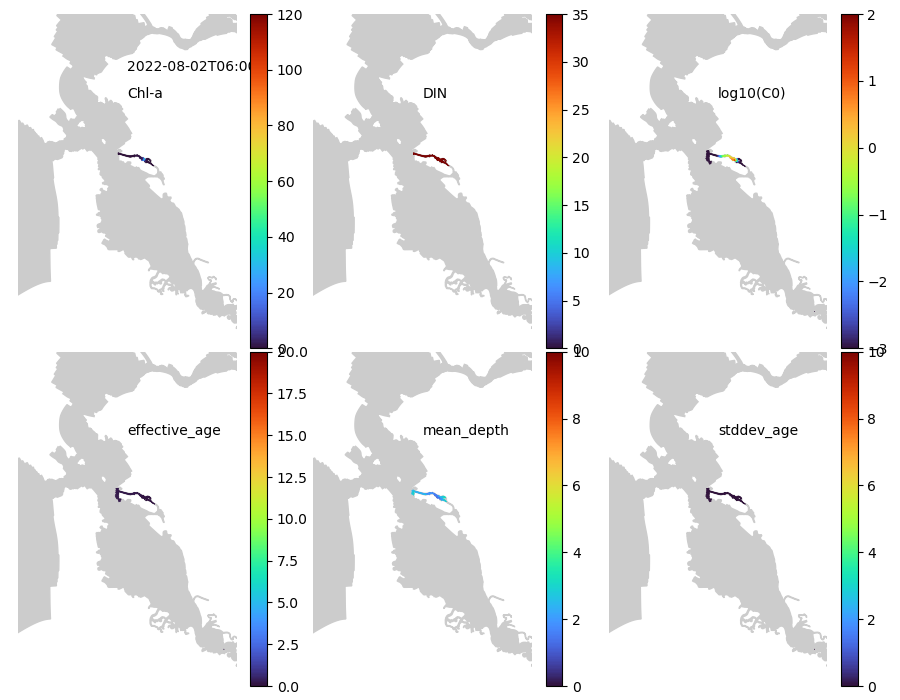

In [36]:
lb=LiveBloom(ds)
lb.t=np.datetime64("2022-08-02 06:00")
#lb.ebda_factor=1.0
lb.run()
lb.figure()

Elapsed time for 2425 samples: 0.261s


<IPython.core.display.Javascript object>


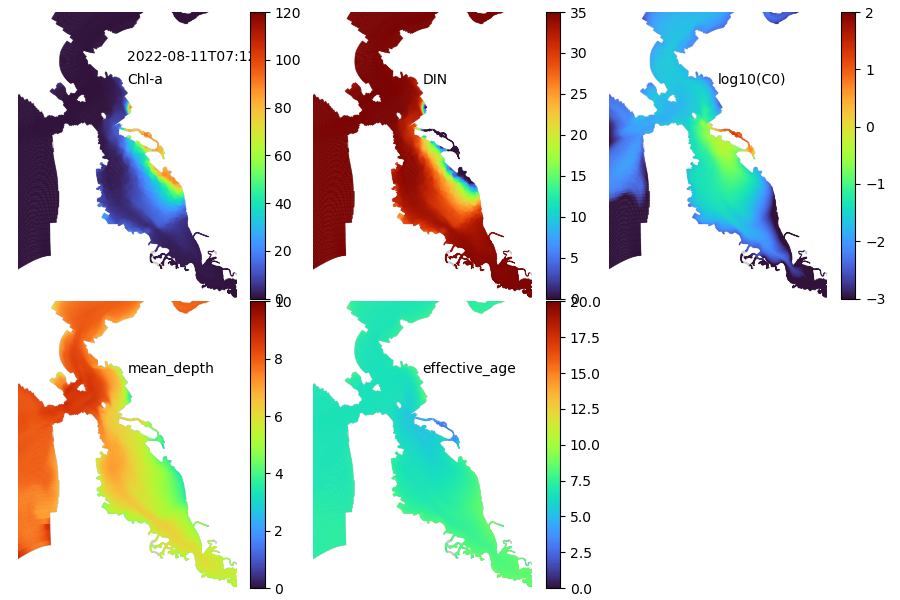

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='days', max=25.0), FloatLogS…

<function __main__.run_and_plot(days=0, ebda_factor=1.0, lsb_factor=1.0, Kd=0.35, kmort=0.15, kprod=1.5, N0=35, source_strength=0.1, layer=0)>

In [37]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

lb=LiveBloom(ds,panels=[['Chl-a','DIN','log10(C0)'],
                        ['mean_depth','effective_age',None]],figsize=(9,6))
lb.run()
lb.figure()

def run_and_plot(days=0,ebda_factor=1.0,lsb_factor=1.0,Kd=0.35,kmort=0.15,kprod=1.5,
                 N0=35,source_strength=0.1,layer=0):
    lb.t=np.datetime64('2022-08-02')+days*np.timedelta64(86400,'s')
    lb.ebda_factor=ebda_factor
    lb.lsb_factor=lsb_factor
    lb.N0=N0
    lb.layer=layer
    lb.source_strength=source_strength
    lb.petri.Kd = Kd
    lb.petri.kmort=kmort
    lb.petri.kprod=kprod
    lb.run()
    lb.figure()
    plt.draw()

interact(run_and_plot,
         days=widgets.FloatSlider(value=0,min=0,max=25,continuous_update=False,step=0.1),
         ebda_factor=widgets.FloatLogSlider(value=1,base=10,min=-5,max=5,step=0.2,
                                            description="EBDA",continuous_update=False),
         lsb_factor=widgets.FloatLogSlider(value=1,base=10,min=-5,max=5,step=0.2,
                                            description="LSB",continuous_update=False),
         kmort=widgets.FloatSlider(value=0.15,min=0,max=1.0,description="kmort",continuous_update=False,
                                   step=0.01),         
         Kd=widgets.FloatSlider(value=0.35,min=0,max=2.5,description="Kd",continuous_update=False,
                               step=0.02),
         N0=widgets.FloatSlider(value=35,min=0,max=100,description="N0",continuous_update=False),
         source_strength=widgets.FloatLogSlider(value=0.1,base=10,min=-3,max=3,step=0.1),
         layer = widgets.IntSlider(value=0,min=0,max=9)
        )


In [ ]:
# Kd=0.42, kmort=0.15, kprod=2.1, N0=35, source=0.1
# Maybe that's a decent tradeoff

In [ ]:
# Updates:
#  Had been using an age that could be much higher than realistic.
#  With that fixed, and bump Kd up to 0.44 -- 0.48, get a bit more reasonable
#  results.
#  Still, it doesn't quite seem right to use such a small age for the Alameda
#  channel water. Since the seed is just a load, not a water source, chl in
#  that water is not resetting to 0 just because some new seed came in.
#  Is it more appropriate to just set everything to max age? I guess there is 
#  some amount of flushing, so in that sense newly seeded water should have
#  a lower age. part of the problem is also that we're getting an arithmetric mean
#  for age, but it's controlling mixing of exponential growth.
#  Generate a new animation, but need to think about whether it makes sense.

In [38]:
# animation
frame_dir=os.path.join(run_dir,"frames-Kd0p42-v0")
movie_fn=os.path.join(frame_dir+".mp4")

In [985]:
lb.ebda_factor=1
lb.lsb_factor=1
lb.N0=35
lb.source_strength=0.1
lb.petri.Kd=0.42
lb.petri.kmort=0.15
lb.petri.kprod=2.1
lb.frac=0.25

if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)
    
for i,t in enumerate(np.arange(np.datetime64("2022-08-02"),
                               np.datetime64("2022-08-22"),
                               np.timedelta64(1800,'s'))):
    img_fn=os.path.join(frame_dir,f"frame_{i:04d}.png")
    lb.t=t
    lb.run()
    lb.figure()
    lb.fig.savefig(img_fn)

Elapsed time for 0 samples: 0.000s
Elapsed time for 42 samples: 0.002s
Elapsed time for 71 samples: 0.004s
Elapsed time for 65 samples: 0.007s
Elapsed time for 88 samples: 0.009s
Elapsed time for 82 samples: 0.005s
Elapsed time for 93 samples: 0.008s
Elapsed time for 114 samples: 0.012s
Elapsed time for 105 samples: 0.011s
Elapsed time for 98 samples: 0.010s
Elapsed time for 130 samples: 0.009s
Elapsed time for 146 samples: 0.015s
Elapsed time for 171 samples: 0.013s
Elapsed time for 215 samples: 0.019s
Elapsed time for 255 samples: 0.017s
Elapsed time for 302 samples: 0.020s
Elapsed time for 332 samples: 0.028s
Elapsed time for 350 samples: 0.028s
Elapsed time for 325 samples: 0.027s
Elapsed time for 348 samples: 0.026s
Elapsed time for 369 samples: 0.031s
Elapsed time for 339 samples: 0.030s
Elapsed time for 331 samples: 0.028s
Elapsed time for 379 samples: 0.032s
Elapsed time for 373 samples: 0.029s
Elapsed time for 431 samples: 0.037s
Elapsed time for 391 samples: 0.034s
Elapsed ti

Elapsed time for 7436 samples: 0.873s
Elapsed time for 7418 samples: 0.876s
Elapsed time for 7566 samples: 0.901s
Elapsed time for 7529 samples: 0.906s
Elapsed time for 7567 samples: 0.908s
Elapsed time for 7502 samples: 0.903s
Elapsed time for 7434 samples: 0.896s
Elapsed time for 7465 samples: 0.911s
Elapsed time for 7448 samples: 0.902s
Elapsed time for 7505 samples: 0.902s
Elapsed time for 7402 samples: 0.895s
Elapsed time for 7376 samples: 0.902s
Elapsed time for 7487 samples: 0.913s
Elapsed time for 7492 samples: 0.916s
Elapsed time for 7453 samples: 0.923s
Elapsed time for 7515 samples: 0.932s
Elapsed time for 7626 samples: 0.939s
Elapsed time for 7303 samples: 0.915s
Elapsed time for 7526 samples: 0.929s
Elapsed time for 7516 samples: 0.940s
Elapsed time for 7751 samples: 0.965s
Elapsed time for 7782 samples: 0.964s
Elapsed time for 7751 samples: 0.968s
Elapsed time for 7930 samples: 0.977s
Elapsed time for 8103 samples: 1.009s
Elapsed time for 8137 samples: 1.015s
Elapsed time

Elapsed time for 11649 samples: 2.103s
Elapsed time for 11719 samples: 2.101s
Elapsed time for 11821 samples: 2.129s
Elapsed time for 11732 samples: 2.120s
Elapsed time for 11717 samples: 2.089s
Elapsed time for 11731 samples: 2.115s
Elapsed time for 11696 samples: 2.128s
Elapsed time for 11764 samples: 2.140s
Elapsed time for 11733 samples: 2.132s
Elapsed time for 11695 samples: 2.093s
Elapsed time for 11684 samples: 2.082s
Elapsed time for 11631 samples: 2.100s
Elapsed time for 11639 samples: 2.068s
Elapsed time for 11693 samples: 2.107s
Elapsed time for 11727 samples: 2.147s
Elapsed time for 11724 samples: 2.129s
Elapsed time for 11741 samples: 2.151s
Elapsed time for 11706 samples: 2.137s
Elapsed time for 11658 samples: 2.158s
Elapsed time for 11753 samples: 2.182s
Elapsed time for 11840 samples: 2.213s
Elapsed time for 11865 samples: 2.240s
Elapsed time for 11810 samples: 2.237s
Elapsed time for 11846 samples: 2.304s
Elapsed time for 11954 samples: 2.341s
Elapsed time for 11775 sa

Elapsed time for 11978 samples: 4.460s
Elapsed time for 11966 samples: 4.377s
Elapsed time for 12215 samples: 4.476s
Elapsed time for 12081 samples: 4.449s
Elapsed time for 11907 samples: 4.413s
Elapsed time for 11983 samples: 4.553s
Elapsed time for 12019 samples: 4.601s
Elapsed time for 12110 samples: 4.747s
Elapsed time for 12104 samples: 4.832s
Elapsed time for 12101 samples: 4.870s
Elapsed time for 12008 samples: 4.965s
Elapsed time for 12106 samples: 5.033s
Elapsed time for 12079 samples: 5.037s
Elapsed time for 11996 samples: 5.200s
Elapsed time for 12131 samples: 5.196s
Elapsed time for 12091 samples: 5.235s
Elapsed time for 11958 samples: 5.165s
Elapsed time for 12054 samples: 5.186s
Elapsed time for 12076 samples: 5.181s
Elapsed time for 12087 samples: 5.186s
Elapsed time for 12042 samples: 5.176s
Elapsed time for 12151 samples: 5.158s
Elapsed time for 12045 samples: 5.046s
Elapsed time for 12176 samples: 4.969s
Elapsed time for 12071 samples: 4.883s
Elapsed time for 11977 sa

Elapsed time for 12086 samples: 6.032s
Elapsed time for 12177 samples: 6.142s
Elapsed time for 11947 samples: 6.041s
Elapsed time for 12057 samples: 6.049s
Elapsed time for 12110 samples: 6.068s
Elapsed time for 12132 samples: 6.094s
Elapsed time for 12195 samples: 6.107s
Elapsed time for 12112 samples: 6.101s
Elapsed time for 12040 samples: 6.055s
Elapsed time for 11970 samples: 5.908s
Elapsed time for 11971 samples: 5.957s
Elapsed time for 11905 samples: 5.825s
Elapsed time for 12037 samples: 5.931s
Elapsed time for 11755 samples: 5.743s
Elapsed time for 12064 samples: 5.878s
Elapsed time for 11917 samples: 5.796s
Elapsed time for 11932 samples: 5.781s
Elapsed time for 11777 samples: 5.759s
Elapsed time for 12048 samples: 5.907s
Elapsed time for 12132 samples: 5.981s
Elapsed time for 12095 samples: 5.935s
Elapsed time for 11862 samples: 5.827s
Elapsed time for 12052 samples: 6.013s
Elapsed time for 12084 samples: 6.040s
Elapsed time for 12229 samples: 6.135s
Elapsed time for 12095 sa

In [ ]:
# Compile to animation


if os.path.exists(movie_fn):
    os.unlink(movie_fn)
subprocess.run(f"ffmpeg -framerate 16 -i {os.path.join(frame_dir,'frame_%04d.png')} "
                "-c:v libx264 -preset slow -profile:v high -level:v 4.0 "
               f"-pix_fmt yuv420p -crf 20 -r 16 {movie_fn}",
               shell=True)
              

In [39]:
Video(movie_fn) # chl limit to 120, DIN to 35, log10(c0) -5,2
# mean _depth to 10, effective age to 20
# but it's not really pushing into the channel as much as I'd like.